In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
# import pyedflib
import os
import glob
# import tensorflow as tf
from tqdm import tqdm
from lxml import etree
from sklearn.model_selection import train_test_split
import random
import multiprocessing as mp
from scipy import signal
import neurokit2 as nk
import pywt
import wfdb
import wfdb.processing
from collections import defaultdict

# Setup

In [2]:
BASE_DB_PATH = '/mnt/dat/databases/shhs/polysomnography'
TO_PATH = '/mnt/dat/prepped/automated_sleep_apnea'
os.makedirs(TO_PATH, exist_ok=True)

TARGET_SAMPLING_RATE = 5

SEGMENT_LENGTH = 30 # input to model
SINGLE_ANNOT = 30 # annotate for every N second
SEGMENT_STRIDE = 1 # second

HALF_SEGMENTS = (SEGMENT_LENGTH // SINGLE_ANNOT) // 2

SAMPLE_RECORD = 'shhs1-200001'

SMALL_PORTION = 1 # get small portion of train/validation for debugging or tuning, 1 to ignore

MULTIPLE_SPLIT = 5

# consider only below channels
SELECTED_CHANNELS = ['ABDO RES', 'THOR RES', # resp signals
                     'ECG'] # to get EDR (ECG derived resp signal)

In [3]:
shhs1_edfs = glob.glob(os.path.join(BASE_DB_PATH, 'edfs/shhs1/*.edf'))
shhs2_edfs = [] # glob.glob(os.path.join(BASE_DB_PATH, 'edfs/shhs2/*.edf')) # only use shhs1
shhs1_edfs = sorted(shhs1_edfs) # only get samples
shhs2_edfs = sorted(shhs2_edfs)

len(shhs1_edfs), len(shhs2_edfs)

(5793, 0)

In [4]:
shhs1_xmls = glob.glob(os.path.join(BASE_DB_PATH, 'annotations-events-nsrr/shhs1/*.xml'))
shhs2_xmls = [] # glob.glob(os.path.join(BASE_DB_PATH, 'annotations-events-nsrr/shhs2/*.xml'))
shhs1_xmls = sorted(shhs1_xmls)
shhs2_xmls = sorted(shhs2_xmls)

len(shhs1_xmls), len(shhs2_xmls)

(5793, 0)

# Examine a sample record

In [5]:
def get_edf(path, channels, split_ecg=False, preload=False):
    if split_ecg:
        resp_edf = mne.io.read_raw_edf(path, include=[c for c in channels if c != "ECG"], 
                                verbose=False, preload=preload)
        ecg_edf = mne.io.read_raw_edf(path, include=["ECG"], 
                                verbose=False, preload=preload)
        return resp_edf, ecg_edf

    return mne.io.read_raw_edf(path, include=channels, 
                                verbose=False, preload=preload)

In [6]:
resp_edf, ecg_edf = get_edf([s for s in shhs1_edfs +  shhs2_edfs if SAMPLE_RECORD in s[s.rfind("/")+1:]][0], 
                            channels=SELECTED_CHANNELS, 
                            split_ecg=True,
                            preload=True)
display(resp_edf)
display(ecg_edf)

<RawEDF | shhs1-200001.edf, 2 x 325200 (32519.9 s), ~5.0 MB, data loaded>

<RawEDF | shhs1-200001.edf, 1 x 4065000 (32520.0 s), ~31.0 MB, data loaded>

In [7]:
def random_window(array, window_size, axis=-1):
    if window_size > array.shape[axis]:
        raise ValueError("Window size must be smaller than or equal to the size of the specified axis.")
    
    start_index = np.random.randint(0, array.shape[axis] - window_size + 1)
    
    slices = [slice(None)] * array.ndim
    slices[axis] = slice(start_index, start_index + window_size)
    
    # Use slicing to extract the random window
    return array[tuple(slices)].copy(), start_index

300


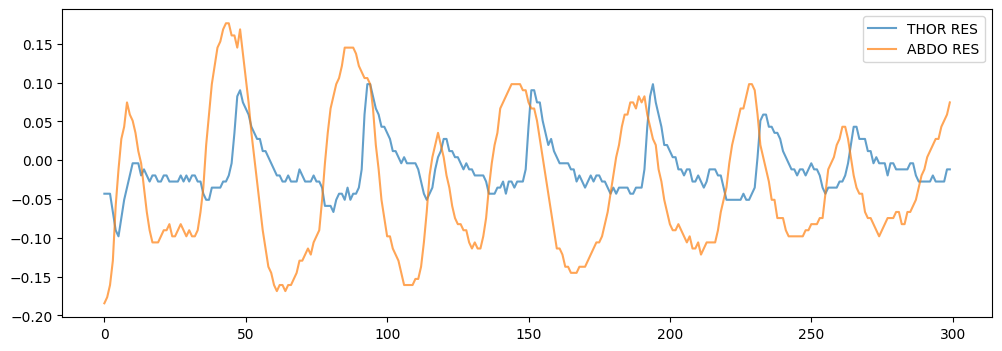

In [8]:
dataa1, _ = random_window(resp_edf.get_data(), window_size=int(30 * resp_edf.info['sfreq']))
print(dataa1.shape[1])
plt.figure(figsize=(12, 4))
sns.lineplot(dataa1[0], label=resp_edf.ch_names[0], alpha=0.7)
sns.lineplot(dataa1[1], label=resp_edf.ch_names[1], alpha=0.7)
plt.show()

3750


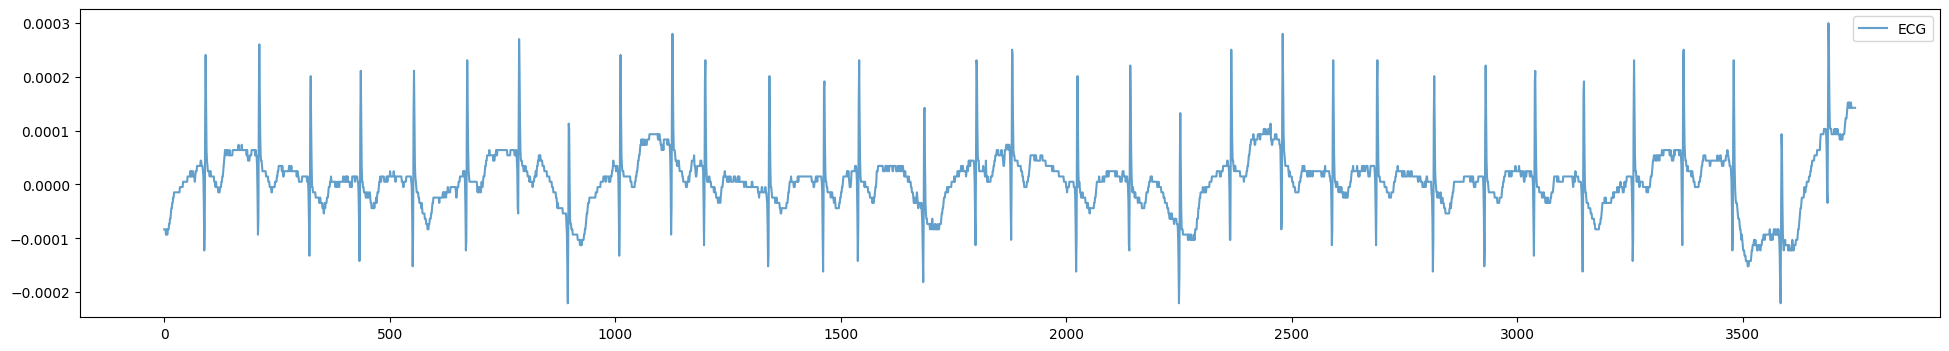

In [9]:
dataa1, _ = random_window(ecg_edf.get_data(), window_size=int(30 * ecg_edf.info['sfreq']))
print(dataa1.shape[1])
plt.figure(figsize=(24, 4))
sns.lineplot(dataa1[0], label=ecg_edf.ch_names[0], alpha=0.7)
plt.show()

# Read annotation

In [10]:
import logging
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def create_annotation(xml_path, start_date, selected_channels=None):
    # Use lxml's fast parser
    parser = etree.XMLParser(remove_blank_text=True, collect_ids=False)
    
    # Use xpath for direct access to elements
    try:
        tree = etree.parse(xml_path, parser)
    except (etree.XMLSyntaxError, OSError) as e:
        raise ValueError(f"Error parsing XML file: {e}")
    
    onset = []
    duration = []
    description = []
    if selected_channels is not None:
        ch_names = []
    
    for event in tree.xpath(".//ScoredEvent"):
        event_name = event.find('EventConcept').text
        if selected_channels is not None:
            ch_name = event.find('SignalLocation')
            if ch_name is None:
                ch_name = []
            elif ch_name.text in selected_channels:
                ch_name = [ch_name.text]
            else:
                ch_name = [] # or ignore by continue

        try:
            start_time = float(event.findtext('Start', default="0.0"))
            sduration = float(event.findtext('Duration', default="0.0"))
        except ValueError:
            logger.warning(f"Invalid start time or duration in event: {etree.tostring(event, pretty_print=True).decode()}")
            continue
        
        onset.append(start_time)
        duration.append(sduration)
        description.append(event_name)
        if selected_channels is not None:
            ch_names.append(ch_name)
    return mne.Annotations(onset=onset, duration=duration, description=description, 
                           ch_names=ch_names if selected_channels is not None else None, # ignore ch_names in annot if not specify
                           orig_time=start_date)

In [11]:
anott = create_annotation([s for s in shhs1_xmls + shhs2_xmls if SAMPLE_RECORD in s][0], resp_edf.info['meas_date'])

resp_edf = resp_edf.set_annotations(anott)
ecg_edf = ecg_edf.set_annotations(anott)

anott.to_data_frame()

,onset,duration,description
0,1985-01-01 22:00:00,840.0,Wake|0
1,1985-01-01 22:00:00,32520.0,Recording Start Time
2,1985-01-01 22:05:04,3.0,SpO2 artifact|SpO2 artifact
3,1985-01-01 22:14:00,30.0,Stage 1 sleep|1
4,1985-01-01 22:14:30,90.0,Stage 2 sleep|2
...,...,...,...
547,1985-01-02 05:43:23,17.0,SpO2 artifact|SpO2 artifact
548,1985-01-02 05:43:53,126.0,SpO2 artifact|SpO2 artifact
549,1985-01-02 05:46:36,90.0,SpO2 artifact|SpO2 artifact
550,1985-01-02 05:48:27,5.0,SpO2 artifact|SpO2 artifact


# Preprocess

## Extract EDR from ECG

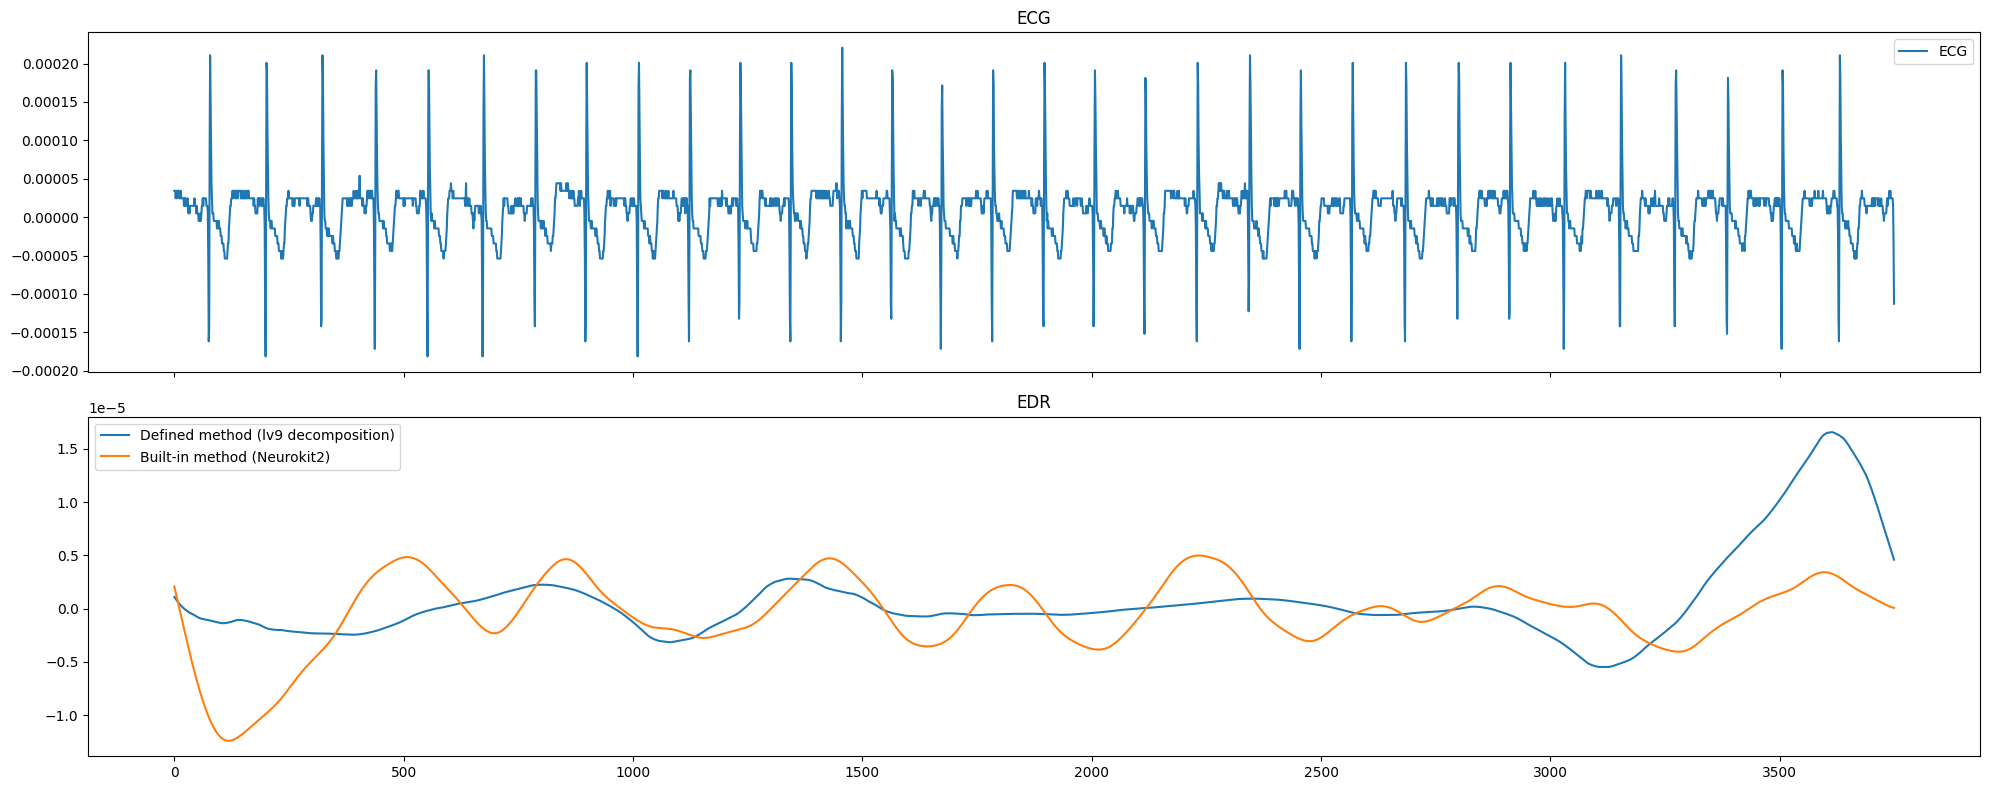

In [12]:
def extract_respiratory_signal(ecg_signal, wavelet='db4', level=9):
    """
    Extract respiratory signal from ECG using Discrete Wavelet Transform
    
    Parameters:
    - ecg_signal: Input ECG signal
    - wavelet: Wavelet type (default: Daubechies 4)
    - level: Decomposition level (default: 9)
    
    Returns:
    - respiratory_signal: Reconstructed respiratory signal
    - decomposition_coeffs: Full wavelet decomposition coefficients
    """
    # Perform Discrete Wavelet Transform
    decomposition_coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    
    # Create a copy of decomposition coefficients for reconstruction
    reconstructed_coeffs = [np.zeros_like(coeff) for coeff in decomposition_coeffs]
    
    # Copy only the detail coefficient at level 9
    reconstructed_coeffs[1] = decomposition_coeffs[1]

    # Reconstruct the signal using the modified coefficients
    respiratory_signal = pywt.waverec(reconstructed_coeffs, wavelet)
    
    return respiratory_signal


fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 8))

ecg_data, _ = random_window(ecg_edf.get_data()[0], window_size=int(30 * ecg_edf.info['sfreq']))
sns.lineplot(ecg_data, ax=axes[0], label='ECG')

axes[0].set_title("ECG")
edr = extract_respiratory_signal(ecg_data, wavelet='db4')
sns.lineplot(edr, ax=axes[1], label='Defined method (lv9 decomposition)')

axes[1].set_title("EDR")
edr1 = nk.ecg_rsp(ecg_data, sampling_rate=ecg_edf.info['sfreq'])
sns.lineplot(edr1, ax=axes[1], label='Built-in method (Neurokit2)')

fig.tight_layout()
plt.show()

In [13]:
# apply to whole signal
edr_og = extract_respiratory_signal(ecg_edf.get_data()[0])
edr_og.shape

(4065000,)

## Put EDR to Resp signals

### Resample to match with ABDO RES and THOR RES

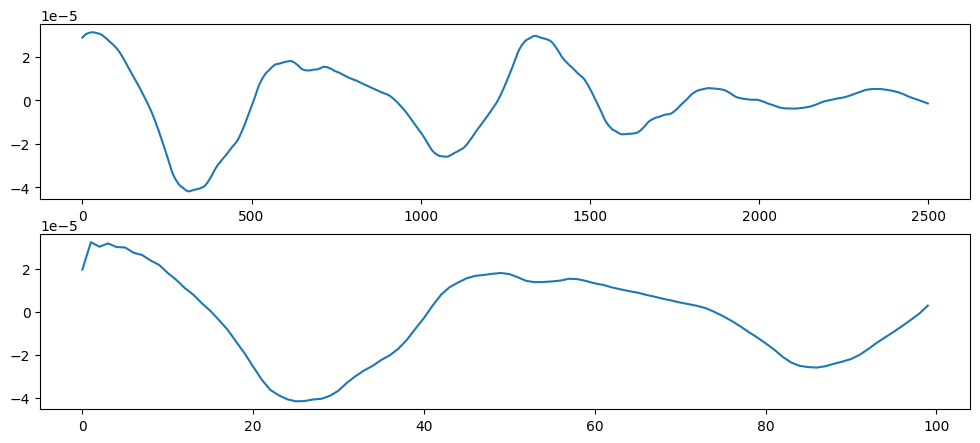

((325200,), np.int64(325200))

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 5))
sns.lineplot(edr_og[:2500], ax=axes[0])

edr, _ = wfdb.processing.resample_sig(edr_og, fs=ecg_edf.info['sfreq'], fs_target=resp_edf.info['sfreq'])

sns.lineplot(edr[:100], ax=axes[1])

plt.show()
edr.shape, resp_edf.n_times

In [15]:
def add_channel_to_raw(raw, new_channel_data, channel_name, channel_type):
    """
    Add a new channel to an existing mne.Raw object.

    Parameters:
    - raw (mne.io.Raw): The original Raw object.
    - new_channel_data (numpy.ndarray): The data for the new channel (shape: (n_samples,)).
    - channel_name (str): The name of the new channel.
    - channel_type (str): The type of the new channel (e.g., 'ecg', 'eog', 'misc').

    Returns:
    - mne.io.Raw: The Raw object with the new channel added.
    """
    
    if len(new_channel_data) != raw.n_times:
        raise ValueError("new_channel_data must have the same number of samples as the existing Raw data.")

    new_info = mne.create_info([channel_name], sfreq=raw.info['sfreq'], ch_types=[channel_type])

    # Reshape the new channel data to (n_channels, n_times)
    new_channel_data = new_channel_data[np.newaxis, :]

    # Create a RawArray for the new channel
    new_raw = mne.io.RawArray(new_channel_data, new_info, verbose=False)

    # Add the new channel to the existing Raw object
    raw.add_channels([new_raw])

    return raw

resp_edf = add_channel_to_raw(resp_edf, edr, "EDR", resp_edf.info.get_channel_types()[0])
resp_edf

<RawEDF | shhs1-200001.edf, 3 x 325200 (32519.9 s), ~7.5 MB, data loaded>

## Filter

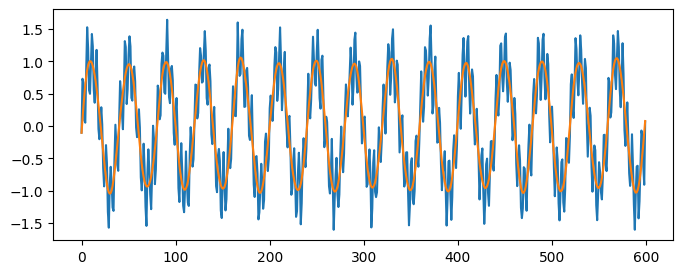

In [16]:
def butterworth_lowpass_filter(data, sampling_rate, cutoff_freq=0.7):
    """
    Apply a fourth-order low-pass zero-phase-shift Butterworth filter.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input signal to be filtered
    cutoff_freq : float
        Cut-off frequency in Hz
    sampling_rate : float
        Sampling rate of the input signal in Hz
    
    Returns:
    --------
    numpy.ndarray
        Filtered signal
    """
    # Nyquist frequency
    nyquist_freq = 0.5 * sampling_rate
    
    # Normalize the cutoff frequency
    normal_cutoff = cutoff_freq / nyquist_freq
    
    # Design the Butterworth filter
    b, a = signal.butter(N=4,  # 4th order
                         Wn=normal_cutoff,  # normalized cutoff frequency
                         btype='low',  # low-pass filter
                         analog=False)  # digital filter
    
    # Apply the filter forward and backward to create zero-phase shift
    filtered_signal = signal.filtfilt(b, a, data)
    
    return filtered_signal


# Simulate a respiratory signal
sampling_rate = 10  # Hz
time = np.linspace(0, 60, 600)  # 60 seconds of data

# Create a sample respiratory signal with noise
respiratory_signal = (
    np.sin(2 * np.pi * 0.25 * time) +  # Respiratory rate ~0.25 Hz
    0.5 * np.sin(2 * np.pi * 2 * time) +  # High-frequency noise
    np.random.normal(0, 0.1, time.shape)  # Random noise
)

# Apply the Butterworth filter
filtered_signal = butterworth_lowpass_filter(
    respiratory_signal, 
    sampling_rate=sampling_rate,
    cutoff_freq=0.7,  # Cut-off at 0.7 Hz 
)

plt.figure(figsize=(8, 3))
plt.plot(respiratory_signal)
plt.plot(filtered_signal)
plt.show()

In [17]:
rawdata = resp_edf.get_data().copy()

processed_data = np.apply_along_axis(lambda x: butterworth_lowpass_filter(x, sampling_rate=int(resp_edf.info['sfreq']), cutoff_freq=0.7), 
                                     axis=1, arr=rawdata)

resp_edf._data = processed_data

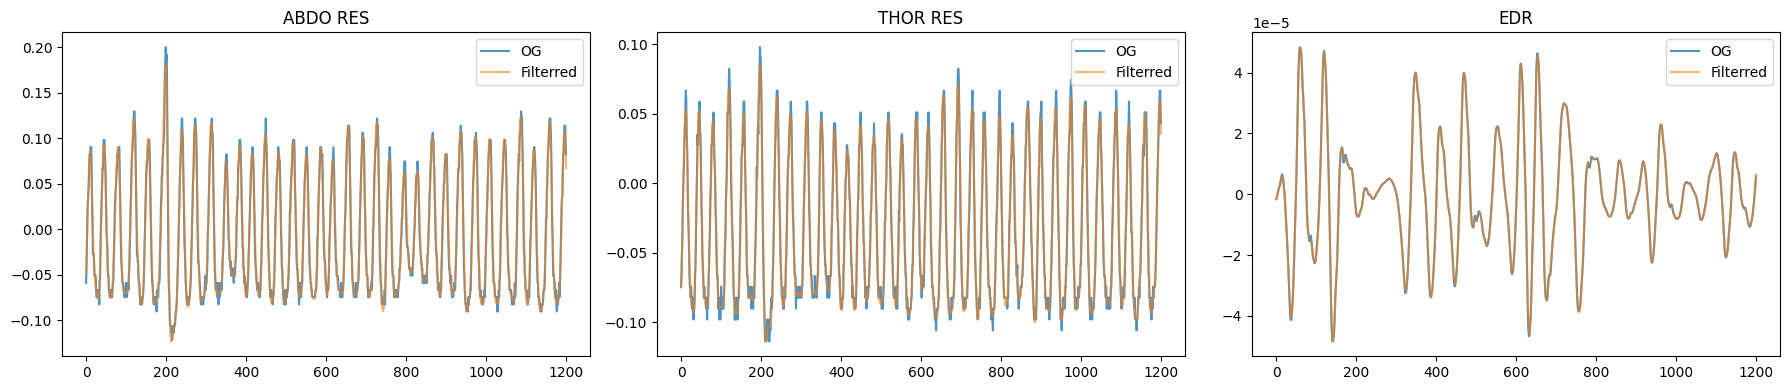

In [18]:
sample_length = int(resp_edf.info['sfreq'] * 120)
random_segment, index = random_window(rawdata, window_size=sample_length)
processed_segment = processed_data[:, index:(index + sample_length)]


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), sharex=True)

axes[0].set_title("ABDO RES")
axes[1].set_title("THOR RES")
axes[2].set_title("EDR")

sns.lineplot(random_segment[0], ax=axes[0], label='OG', alpha=0.8)
sns.lineplot(random_segment[1], ax=axes[1], label='OG', alpha=0.8)
sns.lineplot(random_segment[2], ax=axes[2], label='OG', alpha=0.8)

sns.lineplot(processed_segment[0], ax=axes[0], label='Filterred', alpha=0.6)
sns.lineplot(processed_segment[1], ax=axes[1], label='Filterred', alpha=0.6)
sns.lineplot(processed_segment[2], ax=axes[2], label='Filterred', alpha=0.6)

fig.tight_layout()

plt.show()

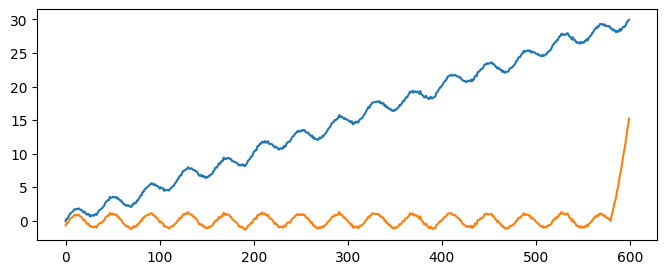

In [19]:
def remove_motion_artifacts(signal_data, sampling_rate, window_width=4):
    """
    Remove motion artifacts and baseline wander by subtracting a moving average 
    filtered signal from the original signal.
    
    Parameters:
    -----------
    signal_data : numpy.ndarray
        Original input signal
    sampling_rate : float
        Sampling rate of the signal (Hz)
    window_width : float, optional
        Width of the moving average window in seconds (default is 4 seconds)
    
    Returns:
    --------
    numpy.ndarray
        Signal with motion artifacts and baseline wander removed
    """
    # Calculate the window size in samples
    window_size = int(window_width * sampling_rate)
    
    # Ensure window size is odd for symmetric filtering
    if window_size % 2 == 0:
        window_size += 1
    
    # Create moving average filter kernel
    moving_average_kernel = np.ones(window_size) / window_size
    
    # Apply moving average filter to the signal
    moving_average_signal = np.convolve(
        signal_data, 
        moving_average_kernel, 
        mode='same'
    )
    
    # Subtract moving average from original signal
    artifact_removed_signal = signal_data - moving_average_signal
    
    return artifact_removed_signal


sampling_rate = 10  # Hz
time = np.linspace(0, 60, 600)  # 60 seconds 
original_signal = (
    np.sin(2 * np.pi * 0.25 * time) + 
    0.5 * time +  # Baseline wander (linear drift)
    0.3 * np.sin(2 * np.pi * 0.1 * time) +  # Low-frequency motion artifact
    np.random.normal(0, 0.1, time.shape)  # Random noise
)

# Remove motion artifacts
cleaned_signal = remove_motion_artifacts(
    original_signal, 
    sampling_rate=sampling_rate,
    window_width=4  # 4-second moving average window
)

plt.figure(figsize=(8, 3))
plt.plot(original_signal)
plt.plot(cleaned_signal)
plt.show()

In [20]:
rawdata = resp_edf.get_data().copy()

processed_data = np.apply_along_axis(lambda x: remove_motion_artifacts(x, sampling_rate=int(resp_edf.info['sfreq']), window_width=4), 
                                     axis=1, arr=rawdata)

resp_edf._data = processed_data

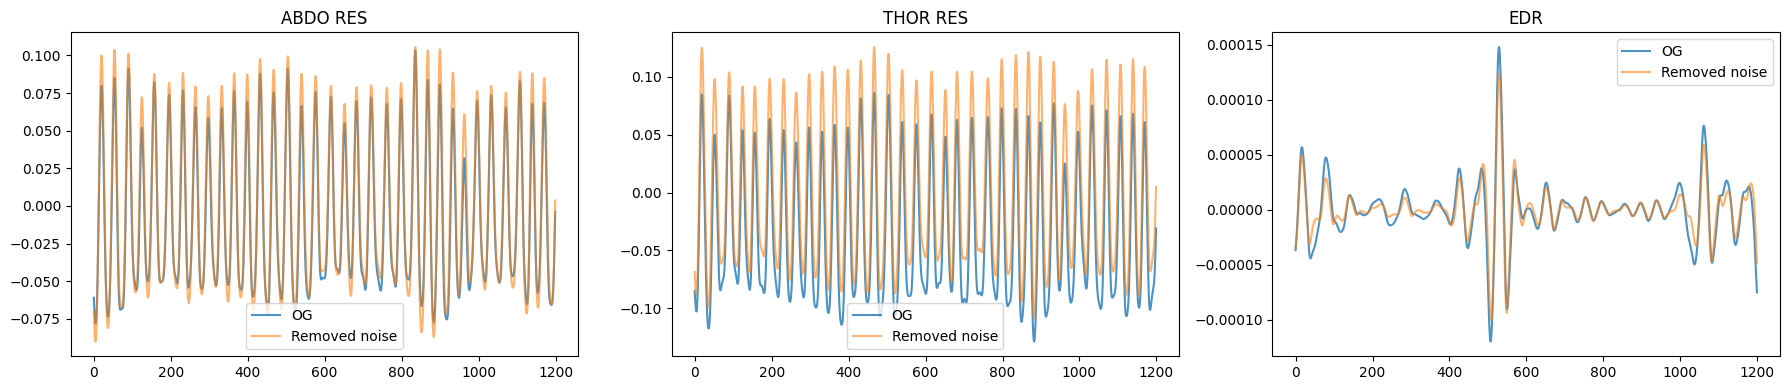

In [21]:
sample_length = int(resp_edf.info['sfreq'] * 120)
random_segment, index = random_window(rawdata, window_size=sample_length)
processed_segment = processed_data[:, index:(index + sample_length)]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), sharex=True)

axes[0].set_title("ABDO RES")
axes[1].set_title("THOR RES")
axes[2].set_title("EDR")

sns.lineplot(random_segment[0], ax=axes[0], label='OG', alpha=0.8)
sns.lineplot(random_segment[1], ax=axes[1], label='OG', alpha=0.8)
sns.lineplot(random_segment[2], ax=axes[2], label='OG', alpha=0.8)

sns.lineplot(processed_segment[0], ax=axes[0], label='Removed noise', alpha=0.6)
sns.lineplot(processed_segment[1], ax=axes[1], label='Removed noise', alpha=0.6)
sns.lineplot(processed_segment[2], ax=axes[2], label='Removed noise', alpha=0.6)

fig.tight_layout()

plt.show()

## Resample all signal to 5Hz

In [22]:
resp_edf.resample(TARGET_SAMPLING_RATE, verbose=False)
resp_edf

<RawEDF | shhs1-200001.edf, 3 x 162600 (32519.8 s), ~3.7 MB, data loaded>

# Split to epoch

"The filtered signals are segmented into 30 second epochs with a stride of 1 second between them."

In [23]:
def split_array_with_indices(arr, axis, 
                                    single_segment_len=(TARGET_SAMPLING_RATE * SEGMENT_LENGTH), 
                                    stride=(TARGET_SAMPLING_RATE * SEGMENT_STRIDE)):
    """
    Calculates the indices for overlapping or non-overlapping segments with a specified stride.

    Parameters:
        arr (np.ndarray): Input array.
        axis (int): The axis along which to split.
        single_segment_len (int): Length of each segment.
        stride (int): Step size between segments.

    Returns:
        list: A list of tuples containing the start and end indices of each segment.
    """
    axis_len = arr.shape[axis]
    num_segments = (axis_len - single_segment_len) // stride + 1

    # Generate start and end indices for each segment
    segment_indices = []

    for i in range(num_segments):
        start = i * stride
        end = start + single_segment_len
        segment_indices.append((start, end))

    return np.array(segment_indices)

split_index = split_array_with_indices(resp_edf.get_data(), axis=1)
split_index.shape

(32491, 2)

# Assign label

"If at the end of an epoch, the sleep technician indicated an apneaic episode, the entire epoch was flagged as a positive apnea episode."

In [24]:
def get_onset_offset(annot: mne.Annotations, label: str):
    adf = annot.to_data_frame()
    adf['lower_desc'] = adf['description'].str.lower()
    selected_df = adf[adf['lower_desc'].str.contains(label)].copy()
    start_time = adf[adf['description'].str.contains('Recording Start Time')]['onset'].iloc[0]
    
    startt = (selected_df["onset"] - start_time).dt.total_seconds().astype(int)
    off = (startt + selected_df["duration"]).astype(int)
    return startt, off

onsets, offsets = get_onset_offset(resp_edf.annotations, 'pnea') # 'apnea' to include OSA and CSA only, 'pnea' to add hypopnea
len(onsets), len(offsets)

(87, 87)

In [25]:
def assign_apnea(onset, offset, 
                 n_times, 
                 sampling_rate=TARGET_SAMPLING_RATE,
                 epoch_len=(TARGET_SAMPLING_RATE * SEGMENT_LENGTH), 
                 stride=(TARGET_SAMPLING_RATE * SEGMENT_STRIDE)):
    
    annot = np.zeros(n_times, dtype=bool) # annotation by each sample
    
    for on, off in zip(onset, offset):
        annot[(on * sampling_rate):(off * sampling_rate)] = 1
    
    split_indices = split_array_with_indices(annot[np.newaxis, :], axis=-1,
                                    single_segment_len=epoch_len,
                                    stride=stride)
    
    label = [] # label by each segment
    
    for start, stop in split_indices:
        last_sec = annot[start:stop][-(1 * TARGET_SAMPLING_RATE):]
        
        if np.all(last_sec == 1): # if entire last 1sec have apnea
            label.append(1)
        else:
            label.append(0)
            
    return np.array(label)

label = assign_apnea(onsets, offsets, resp_edf.n_times)
label.shape

(32491,)

In [26]:
np.unique(label, return_counts=True)

(array([0, 1]), array([30528,  1963]))

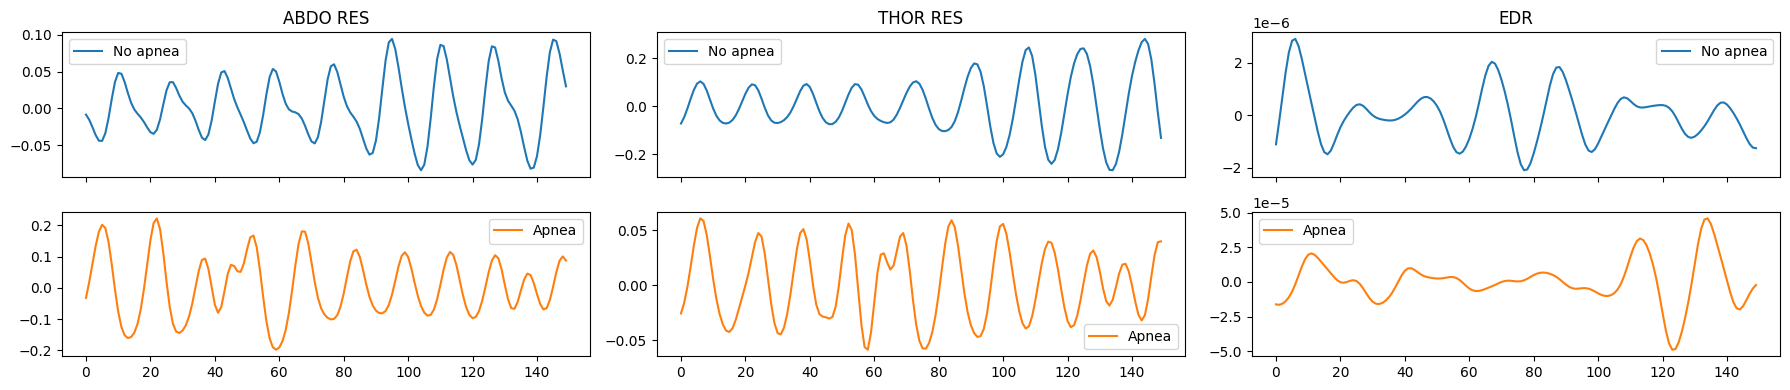

In [27]:
first_nonapnea = np.random.choice(np.where(label == 0)[0], size=1)[0]
first_apnea = np.random.choice(np.where(label == 1)[0], size=1)[0]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 4), sharex=True)

axes[0, 0].set_title("ABDO RES")
axes[0, 1].set_title("THOR RES")
axes[0, 2].set_title("EDR")

x_data = resp_edf.get_data()

segment = split_index[first_nonapnea]
segment = x_data[:, segment[0]:segment[1]]

sns.lineplot(segment[0], ax=axes[0, 0], label='No apnea')
sns.lineplot(segment[1], ax=axes[0, 1], label='No apnea')
sns.lineplot(segment[2], ax=axes[0, 2], label='No apnea')

segment = split_index[first_apnea]
segment = x_data[:, segment[0]:segment[1]]

sns.lineplot(segment[0], ax=axes[1, 0], color='tab:orange', label='Apnea')
sns.lineplot(segment[1], ax=axes[1, 1], color='tab:orange', label='Apnea')
sns.lineplot(segment[2], ax=axes[1, 2], color='tab:orange', label='Apnea')


fig.tight_layout()
plt.show()

# Process on multiple patients

In [28]:
shhs1_df = pd.read_csv(os.path.join(BASE_DB_PATH, '../datasets/shhs1-dataset-0.21.0.csv'), 
                        usecols=['nsrrid', 'weight', 
                                 'hrdur', 'airdur', 'abdodur', 'chestdur',
                                 ],
                        index_col='nsrrid')

shhs_harmonized = pd.read_csv(os.path.join(BASE_DB_PATH, '../datasets/shhs-harmonized-dataset-0.21.0.csv'), 
                        usecols=['nsrrid', 'visitnumber', 'nsrr_age', 'nsrr_sex', 'nsrr_bmi', 'nsrr_ahi_hp3r_aasm15', 'nsrr_ttldursp_f1'])

shhs1_harmonized = shhs_harmonized[shhs_harmonized['visitnumber'] == 1].copy() # select shhs1 only
shhs1_harmonized.set_index('nsrrid', drop=True, inplace=True)
shhs1_harmonized.drop(columns=['visitnumber'], inplace=True)

shhs1_harmonized['nsrr_ttldursp_f1'] = shhs1_harmonized['nsrr_ttldursp_f1'] / 60 # convert sleep minute to hour


shhs1_df = pd.concat([shhs1_df, shhs1_harmonized], axis=1, join='inner')
# rename column
shhs1_df.rename(columns={'nsrr_ahi_hp3r_aasm15': 'ahi',
                         'nsrr_ttldursp_f1': 'sleep_duration'}, inplace=True)

shhs1_df

,weight,hrdur,airdur,chestdur,abdodur,nsrr_age,nsrr_sex,nsrr_bmi,ahi,sleep_duration
nsrrid,,,,,,,,,,
200001,65.0,7,6,7.0,7.0,55.0,male,21.777553,6.23,6.258333
200002,93.0,3,3,3.0,3.0,78.0,male,32.950680,38.24,3.033333
200003,51.0,7,5,7.0,4.0,77.0,female,24.114150,9.37,5.975000
200004,64.0,5,5,5.0,5.0,48.0,male,20.185185,5.18,5.016667
200005,56.0,7,7,7.0,7.0,66.0,female,23.309053,7.46,6.166667
...,...,...,...,...,...,...,...,...,...,...
205800,70.5,7,4,5.0,7.0,66.0,male,25.693134,61.55,5.491667
205801,83.6,7,3,7.0,3.0,54.0,male,26.730372,24.88,6.591667
205802,75.0,7,6,7.0,7.0,55.0,male,24.228571,12.12,6.933333


## Select patients with at least 6 hour of useful data

In [29]:
shhs1_df.columns[shhs1_df.columns.str.endswith('dur')]

Index(['hrdur', 'airdur', 'chestdur', 'abdodur'], dtype='object')

In [30]:
dur_cols = shhs1_df.columns[shhs1_df.columns.str.endswith('dur')]
cond = (shhs1_df.loc[:, dur_cols] >= 6).all(axis=1) # at least 6 hour of useful data
shhs1_df = shhs1_df[cond].copy()
shhs1_df.drop(columns=dur_cols, inplace=True)
len(shhs1_df)

2111

In [31]:
# assign ahi label
bins = [-float('inf'), 5, 15, 30, float('inf')]  # Define bins for ranges
labels = ['none', 'mild', 'moderate', 'severe']  # Corresponding labels

shhs1_df['ahi_label'] = pd.cut(shhs1_df['ahi'], bins=bins, labels=labels, right=False)
shhs1_df

,weight,nsrr_age,nsrr_sex,nsrr_bmi,ahi,sleep_duration,ahi_label
nsrrid,,,,,,,
200001,65.0,55.0,male,21.777553,6.23,6.258333,mild
200005,56.0,66.0,female,23.309053,7.46,6.166667,mild
200008,62.0,63.0,female,25.230112,4.12,5.583333,none
200014,85.0,75.0,male,30.795848,24.16,6.125000,moderate
200016,95.0,60.0,male,29.475309,12.24,6.125000,mild
...,...,...,...,...,...,...,...
205797,48.2,55.0,female,21.957367,2.10,6.191667,none
205798,91.8,59.0,male,30.648232,22.92,7.200000,moderate
205802,75.0,55.0,male,24.228571,12.12,6.933333,mild


In [32]:
all_record = {}

for path in shhs1_xmls + shhs2_xmls:
    record = path[path.rfind("/") + 1:path.rfind("-nsrr.xml")]
    all_record[record] = [None, path]

for path in shhs1_edfs + shhs2_edfs:
    record = path[path.rfind("/") + 1:path.rfind(".edf")]
    all_record[record][0] = path


all_record = pd.DataFrame(all_record).T
all_record.index.name = 'nsrrid'
all_record = all_record.rename(columns={0: 'EDF_path', 1: 'XML_path'})
# all_record.reset_index(inplace=True)
all_record

,EDF_path,XML_path
nsrrid,,
shhs1-200001,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200002,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200003,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200004,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200005,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
...,...,...
shhs1-205800,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-205801,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-205802,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...


In [33]:
# join path
shhs1_df.index = 'shhs1-' + shhs1_df.index.astype(str)

shhs1_df = pd.concat([shhs1_df, all_record], axis=1, join='inner')
shhs1_df

,weight,nsrr_age,nsrr_sex,nsrr_bmi,ahi,sleep_duration,ahi_label,EDF_path,XML_path
nsrrid,,,,,,,,,
shhs1-200001,65.0,55.0,male,21.777553,6.23,6.258333,mild,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200005,56.0,66.0,female,23.309053,7.46,6.166667,mild,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200008,62.0,63.0,female,25.230112,4.12,5.583333,none,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200014,85.0,75.0,male,30.795848,24.16,6.125000,moderate,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200016,95.0,60.0,male,29.475309,12.24,6.125000,mild,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
...,...,...,...,...,...,...,...,...,...
shhs1-205797,48.2,55.0,female,21.957367,2.10,6.191667,none,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-205798,91.8,59.0,male,30.648232,22.92,7.200000,moderate,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-205802,75.0,55.0,male,24.228571,12.12,6.933333,mild,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...


In [34]:
# compare below result with paper (A. Dataset section)

print(shhs1_df['nsrr_sex'].value_counts())
shhs1_df.describe() 

nsrr_sex
female    1075
male      1033
Name: count, dtype: int64


,weight,nsrr_age,nsrr_bmi,ahi,sleep_duration
count,2073.000000,2108.000000,2096.000000,2108.000000,2108.000000
mean,76.891457,63.061670,27.683331,18.565180,6.254598
std,15.255517,11.274417,4.688813,16.317583,0.961487
min,47.000000,39.000000,18.000000,0.000000,2.275000
25%,65.900000,55.000000,24.446922,6.985000,5.650000
50%,76.400000,63.000000,27.287888,13.475000,6.341667
75%,86.400000,72.000000,30.225239,24.500000,6.943750
max,126.000000,90.000000,50.000000,116.300000,8.575000


In [35]:
shhs1_df.groupby('ahi_label', observed=True)['ahi'].describe()

,count,mean,std,min,25%,50%,75%,max
ahi_label,,,,,,,,
none,341.0,3.078094,1.264201,0.00,2.110,3.180,4.1800,4.99
mild,804.0,9.611716,2.845106,5.01,7.170,9.535,11.9400,14.98
moderate,578.0,21.369948,4.179687,15.02,17.675,21.135,24.3875,29.97
severe,385.0,46.769143,15.039212,30.08,34.950,42.700,53.5800,116.30


In [36]:
shhs1_df = shhs1_df.loc[:, ['ahi', 'ahi_label', 'sleep_duration', 'EDF_path', 'XML_path']]
shhs1_df

,ahi,ahi_label,sleep_duration,EDF_path,XML_path
nsrrid,,,,,
shhs1-200001,6.23,mild,6.258333,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200005,7.46,mild,6.166667,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200008,4.12,none,5.583333,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200014,24.16,moderate,6.125000,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-200016,12.24,mild,6.125000,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
...,...,...,...,...,...
shhs1-205797,2.10,none,6.191667,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-205798,22.92,moderate,7.200000,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...
shhs1-205802,12.12,mild,6.933333,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...


# Preload for later process

Remove missing records with missing channel (must contain ABDO RES, THOR RES, ECG) and preload label for bootstrapping


In [ ]:

def preload_row(args):
    nsrrid, row = args
    if row['EDF_path'] is None or row['XML_path'] is None:
        return nsrrid, None
    try:
        resp_edf, ecg_edf = get_edf(row['EDF_path'], SELECTED_CHANNELS, split_ecg=True, preload=False)
        if len(resp_edf.ch_names) + len(ecg_edf.ch_names) < 3: # missing channels
            return nsrrid, None

        anno = create_annotation(row['XML_path'], resp_edf.info['meas_date'], None)
        onsets, offsets = get_onset_offset(anno, 'pnea')
        target_ntimes = int(resp_edf.n_times * TARGET_SAMPLING_RATE / resp_edf.info['sfreq'])
        label = assign_apnea(onsets, offsets, target_ntimes)
        
        processed_path = os.path.join(TO_PATH, f"preprocessed/{nsrrid}.npz")
        
        if not os.path.exists(processed_path):
            resp_edf.load_data(verbose=False)
            ecg_edf.load_data(verbose=False)
            
            edr_og = extract_respiratory_signal(ecg_edf.get_data()[0])
            edr, _ = wfdb.processing.resample_sig(edr_og, fs=ecg_edf.info['sfreq'], fs_target=resp_edf.info['sfreq'])
            resp_edf = add_channel_to_raw(resp_edf, edr, "EDR", resp_edf.info.get_channel_types()[0])
            
            rawdata = resp_edf.get_data().copy()
            processed_data = np.apply_along_axis(lambda x: butterworth_lowpass_filter(x, sampling_rate=int(resp_edf.info['sfreq']), cutoff_freq=0.7), 
                                                axis=1, arr=rawdata)
            processed_data = np.apply_along_axis(lambda x: remove_motion_artifacts(x, sampling_rate=int(resp_edf.info['sfreq']), window_width=4), 
                                                axis=1, arr=processed_data)
            resp_edf._data = processed_data
            
            resp_edf.resample(TARGET_SAMPLING_RATE, verbose=False)
            
            np.savez_compressed(processed_path, resp_edf.get_data())
        
        x_data = np.load(os.path.join(TO_PATH, f"preprocessed/{nsrrid}.npz"), mmap_mode='r')['arr_0']
        split_indices = split_array_with_indices(x_data, axis=-1)
        
        return nsrrid, (x_data, split_indices, label)
    
    except Exception as e:
        print(f"Error processing nsrrid {nsrrid}: {e}")
        return nsrrid, None

def process_dataframe_in_parallel(df, num_workers=None):
    os.makedirs(os.path.join(TO_PATH, "preprocessed"), exist_ok=True)
    
    if num_workers is None:
        num_workers = mp.cpu_count() - 4

    with mp.Pool(num_workers) as pool:
        results = list(tqdm(pool.imap(preload_row, df.iterrows()), total=len(df)))

    remove_rows = []
    for nsrrid, res in results:
        if res is None:
            remove_rows.append(nsrrid)
        else:
            shhs1_df.at[nsrrid, 'X_data'] = res[0]
            shhs1_df.at[nsrrid, 'Split'] = res[1]
            shhs1_df.at[nsrrid, 'Label'] = res[2]
    return remove_rows

shhs1_df['X_data'] = None
shhs1_df['Split'] = None
shhs1_df['Label'] = None

remove_rows = process_dataframe_in_parallel(shhs1_df)
shhs1_df.drop(index=remove_rows, inplace=True)
shhs1_df

100%|██████████| 2108/2108 [00:21<00:00, 96.62it/s] 


,ahi,ahi_label,sleep_duration,EDF_path,XML_path,X_data,Split,Label
nsrrid,,,,,,,,
shhs1-200001,6.23,mild,6.258333,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[0.21977690650502407, 0.1255705184110138, 0.0...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
shhs1-200005,7.46,mild,6.166667,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[0.01006318262545533, 0.1378857101389496, 0.2...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
shhs1-200008,4.12,none,5.583333,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.15833280348014545, -0.1277928056887152, -...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
shhs1-200014,24.16,moderate,6.125000,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.24402678280847456, -0.1793097973030306, -...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
shhs1-200016,12.24,mild,6.125000,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.16790004762656313, -0.1465575159290679, -...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
shhs1-205797,2.10,none,6.191667,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.0810258726291396, 0.059756322108209955, 0...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
shhs1-205798,22.92,moderate,7.200000,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.43824249090343453, -0.25394593710344193, ...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
shhs1-205802,12.12,mild,6.933333,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.09822900344072458, -0.013336589342592714,...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [38]:
shhs1_df.reset_index(inplace=True)
shhs1_df['id'] = shhs1_df['nsrrid'].str.removeprefix("shhs1-").astype("int")
shhs1_df.set_index('id', drop=True, inplace=True)
shhs1_df

,nsrrid,ahi,ahi_label,sleep_duration,EDF_path,XML_path,X_data,Split,Label
id,,,,,,,,,
200001,shhs1-200001,6.23,mild,6.258333,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[0.21977690650502407, 0.1255705184110138, 0.0...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
200005,shhs1-200005,7.46,mild,6.166667,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[0.01006318262545533, 0.1378857101389496, 0.2...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
200008,shhs1-200008,4.12,none,5.583333,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.15833280348014545, -0.1277928056887152, -...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
200014,shhs1-200014,24.16,moderate,6.125000,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.24402678280847456, -0.1793097973030306, -...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
200016,shhs1-200016,12.24,mild,6.125000,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.16790004762656313, -0.1465575159290679, -...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
205797,shhs1-205797,2.10,none,6.191667,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.0810258726291396, 0.059756322108209955, 0...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
205798,shhs1-205798,22.92,moderate,7.200000,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.43824249090343453, -0.25394593710344193, ...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
205802,shhs1-205802,12.12,mild,6.933333,/mnt/dat/databases/shhs/polysomnography/edfs/s...,/mnt/dat/databases/shhs/polysomnography/annota...,"[[-0.09822900344072458, -0.013336589342592714,...","[[0, 150], [5, 155], [10, 160], [15, 165], [20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [40]:
window_df = defaultdict(list)
for i, row in tqdm(shhs1_df.iterrows(), total=len(shhs1_df)):
    window_df['Record_id'].extend([row.name] * len(row['Label']))
    window_df['Split'].extend(row['Split'])
    window_df['Label'].extend(row['Label'])

window_df = pd.DataFrame(window_df)
window_df

100%|██████████| 2108/2108 [00:05<00:00, 376.37it/s]


,Record_id,Split,Label
0,200001,"[0, 150]",0
1,200001,"[5, 155]",0
2,200001,"[10, 160]",0
3,200001,"[15, 165]",0
4,200001,"[20, 170]",0
...,...,...,...
64616283,205804,"[152380, 152530]",0
64616284,205804,"[152385, 152535]",0
64616285,205804,"[152390, 152540]",0
64616286,205804,"[152395, 152545]",0


In [41]:
window_df['Label'].value_counts()

Label
0    52881286
1    11735002
Name: count, dtype: int64

# Prepare

In [42]:
import tensorflow as tf

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    """Returns an int64_list from an integer or list of integers."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def serialize_example(ext, label, name=None):
    """Serialize the X and y data into a TFRecord example."""
    feature = {'ext': _float_feature(ext.flatten())}
    
    if label is not None:
        feature['label'] = _int64_feature(label.flatten())
    if name is not None:
        feature['name'] = _bytes_feature(name)
        
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

2024-12-16 13:47:16.722477: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 13:47:16.818165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734331636.863416   18337 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734331636.882596   18337 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 13:47:16.986824: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [43]:
OPTIONS = tf.io.TFRecordOptions(compression_type="GZIP")

In [44]:
def process_row(row):
    record_id = row['Record_id']
    split = row['Split']
    y = row['Label']
    
    x = shhs1_df.loc[record_id]['X_data']
    
    x = x[:, split[0]:split[1]]
    
    example = serialize_example(x, np.array([y]))
    return example

def write_to_tfrecord(queue, output_file):
    with tf.io.TFRecordWriter(output_file, options=OPTIONS) as writer:
        while True:
            item = queue.get()
            if item is None:  # Sentinel value to indicate end of data
                break
            writer.write(item)

def main(df: pd.DataFrame, save_name, test=False, num_processes=None, verbose=True):
    num_processes = mp.cpu_count() - 4 if num_processes is None else num_processes
    output_file = os.path.join(save_name)
    
    if num_processes > 1:
        # Multiprocessing setup
        pool = mp.Pool(processes=num_processes)
        manager = mp.Manager()
        queue = manager.Queue(maxsize=10000)  # Limit queue size to avoid OOM
        writer_process = mp.Process(target=write_to_tfrecord, args=(queue, output_file))
        writer_process.start()

        iterator = pool.imap(process_row, (row for _, row in df.iterrows()))
        if verbose:
            iterator = tqdm(iterator, desc=f"Preparing {os.path.basename(save_name)}", total=len(df))
        
        for result in iterator:
            queue.put(result)

        # Signal the writer process to finish
        queue.put(None)
        writer_process.join()

        # Close and join the pool
        pool.close()
        pool.join()
    
    else:
        # Single-process setup
        with tf.io.TFRecordWriter(output_file, options=OPTIONS) as writer:
            iterator = (process_row(row) for _, row in df.iterrows())
            if verbose:
                iterator = tqdm(iterator, total=len(df))
            
            for example in iterator:
                writer.write(example)
    
    return f"File {save_name} completed."


In [47]:
random_states = random.sample(range(1, 100 + 1), MULTIPLE_SPLIT)
random_states

[53, 51, 84, 25, 66]

In [ ]:
for state in random_states:
    # shhs1_df = shhs1_df.sample(frac=SMALL_PORTION, random_state=state)
    window_df = window_df[window_df['Record_id'].isin(shhs1_df.index)]
    window_df = window_df.sample(frac=1, random_state=state) # shuffle
    
    train_df, test_df = train_test_split(shhs1_df, train_size=100, 
                                                random_state=state, 
                                                stratify=shhs1_df['ahi_label']) # should use AHI

    test_window_df = window_df[window_df['Record_id'].isin(test_df.index)]
    train_window_df = window_df[window_df['Record_id'].isin(train_df.index)]

    zero_df = train_window_df[train_window_df['Label'] == 0]
    one_df = train_window_df[train_window_df['Label'] == 1]
    
    n_datasets = len(zero_df) // len(one_df)
    sub_datasets = []
    for i in range(n_datasets):
        start = i * len(one_df)
        stop = min((i + 1) * len(one_df), len(zero_df))
        
        subset = pd.concat([zero_df.iloc[start:stop], one_df], axis=0)
        sub_datasets.append(subset)
    
    for i, subset in enumerate(sub_datasets):
        train_set, validation_set = train_test_split(subset, test_size=0.2, 
                                                        random_state=state)
        
        names = ["train", "val"]
        if SMALL_PORTION != 1:
            names = [n + "_sub" for n in names]
        names = [f"{n}_state_{state}_part_{i}.tfrecord" for n in names]
        
        if len(train_set):
            result = main(train_set, os.path.join(TO_PATH, names[0]), num_processes=8)
            # print(result)
        
        if len(validation_set):
            result = main(validation_set, os.path.join(TO_PATH, names[1]), num_processes=8)
            # print(result)
    
    # # temporarily ignore test (too big), should be created later in evaluation
    
    # if len(test_window_df):
    #     result = main(test_window_df, os.path.join(TO_PATH, f"test_state_{state}.tfrecord"), num_processes=8)
        # print(result)

Preparing train_state_53_part_0.tfrecord:   1%|          | 6035/866811 [00:09<19:52, 721.77it/s]